In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
import random

# Load Dataset

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "KMC_Dataset_for_grading (1)" 
image_size = (224, 224)
num_classes = 5

# Get all image paths from both folders 
normal_image_paths = glob(os.path.join(dataset_path, "0 (1)", "*.jpg"))
G1_image_paths = glob(os.path.join(dataset_path, "1 (1)", "*.jpg"))
G2_image_paths = glob(os.path.join(dataset_path, "2 (1)", "*.jpg"))
G3_image_paths = glob(os.path.join(dataset_path, "3 (1)", "*.jpg"))
G4_image_paths = glob(os.path.join(dataset_path, "4 (1)", "*.jpg"))

# Combine the paths and shuffle them
image_paths = normal_image_paths + G1_image_paths + G2_image_paths + G3_image_paths + G4_image_paths
random.shuffle(image_paths)

# Split the image paths into train and test sets
train_ratio = 0.8  
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Check device
print(device)

# Print the number of images in each set for verification
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")


cpu
Total images: 2228
Training set size: 1782
Testing set size: 446


In [10]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [12]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN

In [14]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model =CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)


Epoch 0,   Train Loss: 0.4304, Train Accuracy: 81.87%
Eval Loss: 0.2384, Eval Accuracy: 86.10%
######################################################################
Epoch 1,   Train Loss: 0.2412, Train Accuracy: 88.61%
Eval Loss: 0.1619, Eval Accuracy: 91.93%
######################################################################
Epoch 2,   Train Loss: 0.2251, Train Accuracy: 89.28%
Eval Loss: 0.2769, Eval Accuracy: 85.65%
######################################################################
Epoch 3,   Train Loss: 0.1898, Train Accuracy: 90.35%
Eval Loss: 0.5191, Eval Accuracy: 81.17%
######################################################################
Epoch 4,   Train Loss: 0.2608, Train Accuracy: 88.16%
Eval Loss: 0.1527, Eval Accuracy: 90.13%
######################################################################
Epoch 5,   Train Loss: 0.1792, Train Accuracy: 90.57%
Eval Loss: 0.1391, Eval Accuracy: 92.38%
######################################################################
Epoc

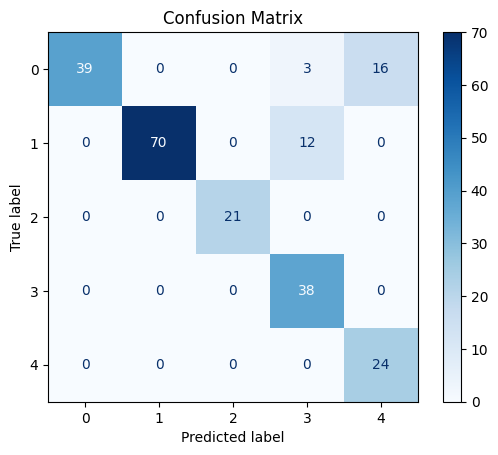

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        58
           1       1.00      0.85      0.92        82
           2       1.00      1.00      1.00        21
           3       0.72      1.00      0.84        38
           4       0.60      1.00      0.75        24

    accuracy                           0.86       223
   macro avg       0.86      0.91      0.86       223
weighted avg       0.91      0.86      0.87       223



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming these lists are defined somewhere in your code
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_score = float("inf")
n_epochs = 10
tolerance = 0

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def eval_model():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def get_predictions_and_labels():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)  # Adjust based on the number of items your DataLoader returns
            labels = batch[1].to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

# Generate predictions and true labels
preds, true_labels = get_predictions_and_labels()
# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Print classification report
print("Classification Report:")
print(classification_report(true_labels, preds))


# Mobilenet

Epoch 1: Train Loss: 0.3061, Train Acc: 86.92%, Val Loss: 0.1320, Val Acc: 92.83%
Epoch 2: Train Loss: 0.1553, Train Acc: 90.74%, Val Loss: 0.1347, Val Acc: 92.38%
Epoch 3: Train Loss: 0.1437, Train Acc: 92.03%, Val Loss: 0.1297, Val Acc: 92.38%
Epoch 4: Train Loss: 0.1365, Train Acc: 93.10%, Val Loss: 0.1502, Val Acc: 92.38%
Epoch 5: Train Loss: 0.1368, Train Acc: 92.54%, Val Loss: 0.1289, Val Acc: 91.93%
Epoch 6: Train Loss: 0.1250, Train Acc: 93.32%, Val Loss: 0.1448, Val Acc: 90.13%
Epoch 7: Train Loss: 0.1243, Train Acc: 94.44%, Val Loss: 0.4420, Val Acc: 88.79%
Epoch 8: Train Loss: 0.1239, Train Acc: 94.11%, Val Loss: 0.1343, Val Acc: 91.48%
Epoch 9: Train Loss: 0.1024, Train Acc: 95.17%, Val Loss: 0.1704, Val Acc: 92.83%
Epoch 10: Train Loss: 0.0922, Train Acc: 95.68%, Val Loss: 0.1637, Val Acc: 93.27%


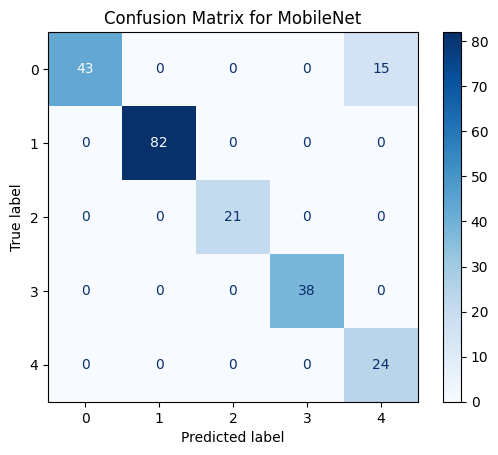

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        58
           1       1.00      1.00      1.00        82
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        38
           4       0.62      1.00      0.76        24

    accuracy                           0.93       223
   macro avg       0.92      0.95      0.92       223
weighted avg       0.96      0.93      0.94       223



In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Loaders as previously defined
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition
class MobileNetModel(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetModel, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetModel(num_classes=5).to(device)  # Set num_classes appropriately
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "mobilenet.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MobileNet")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))
